In [1]:
import os
import platform
import sys

import tensorflow as tf
from tensorflow.keras import layers

2023-02-23 12:37:13.564464: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 12:37:14.485067: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-23 12:37:14.485127: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-23 12:37:14.485134: W tensorfl

In [2]:
%matplotlib widget

In [3]:
print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print()
print(f"Python {sys.version}")

Python Platform: Linux-6.1.12-zen1-1-zen-x86_64-with-glibc2.29
Tensor Flow Version: 2.11.0
Keras Version: 2.11.0

Python 3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0]


The TF_GPU_ALLOCATOR environment variable is used to specify the GPU memory allocator that TensorFlow should use. The cuda_malloc_async allocator is an asynchronous memory allocator that is optimized for use with NVIDIA GPUs.

In [4]:
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

The os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] assignment sets an environment variable called TF_FORCE_GPU_ALLOW_GROWTH in the operating system. This environment variable tells TensorFlow to dynamically grow the GPU memory usage as needed, rather than allocating all of the GPU memory at the start of the TensorFlow session.

In [5]:
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH']= 'true'

In [6]:
tf.get_logger().setLevel("INFO")

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}

Method 1: This enables the dynamic allocation of GPU memory. 

In [7]:
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2023-02-23 12:37:15.913373: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-23 12:37:15.921891: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-23 12:37:15.922160: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Method 2: This enables the dynamic allocation of GPU memory. 

In [8]:
# Ref: https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
# Restrict TensorFlow to only allocate 1GB of memory on the first GPU
#  try:
#    tf.config.experimental.set_virtual_device_configuration(
#        gpus[0],
#        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) # Notice here
#    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#  except RuntimeError as e:
# Virtual devices must be set before GPUs have been initialized
#    print(e)

Checks for the GPU available and lists it

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


In [10]:
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
device_lib.list_local_devices()

Num GPUs Available:  1


2023-02-23 12:37:15.934942: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 12:37:15.936166: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-23 12:37:15.936363: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-23 12:37:15.936476: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13052878046894235646
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4302766080
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6211765267433239045
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [11]:
import os
import sys

import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.layers import Dense, Flatten, Input
from keras.models import Model


def escape():
    sys.exit()

In [12]:
import_directory = "/spectre-code/dataset/PCAP-NPY/"
counter = 0
data_array = np.empty((0, 2))
files = os.listdir(import_directory)
for file in files:
    print("Opening File : ", file)
    data_set = np.load(import_directory + file, allow_pickle=True)
    data_array = np.vstack((data_array, data_set))

# separated = np.array([x for x in data_array if x[1] == 0])

Opening File :  destinationPayload_TestbedMonJun14Flows.xml.npy
Opening File :  destinationPayload_TestbedSatJun12Flows.xml.npy
Opening File :  destinationPayload_TestbedSunJun13Flows.xml.npy
Opening File :  destinationPayload_TestbedThuJun17-2Flows.xml.npy
Opening File :  destinationPayload_TestbedThuJun17-3Flows.xml.npy
Opening File :  destinationPayload_TestbedTueJun15-1Flows.xml.npy
Opening File :  destinationPayload_TestbedTueJun15-2Flows.xml.npy
Opening File :  destinationPayload_TestbedTueJun15-3Flows.xml.npy
Opening File :  destinationPayload_TestbedWedJun16-1Flows.xml.npy
Opening File :  destinationPayload_TestbedWedJun16-2Flows.xml.npy
Opening File :  destinationPayload_TestbedWedJun16-3Flows.xml.npy


In [13]:
# np.random.shuffle(separated)
np.random.shuffle(data_array)
print("ok")

ok


In [14]:
img_row = 50
img_col = 50

N = np.shape(data_array)[0]
train_test_split_percentage = 0.75

X_train = data_array[: int(N * train_test_split_percentage), 0]
X_test = data_array[int(N * train_test_split_percentage) :, 0]

X_train = np.array([x.reshape(img_row, img_col, 3) for x in X_train])
X_test = np.array([x.reshape(img_row, img_col, 3) for x in X_test])

In [15]:
y_train = data_array[: int(N * train_test_split_percentage), 1]
y_test = data_array[int(N * train_test_split_percentage) :, 1]

y_train = np.array([[x] for x in y_train])
y_test = np.array([[x] for x in y_test])

In [16]:
model_vgg19_conv = VGG19(
    include_top=False, weights="imagenet", input_shape=(img_col, img_row, 3)
)

2023-02-23 12:37:37.249259: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-23 12:37:37.249768: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-23 12:37:37.249898: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-23 12:37:37.250136: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-23 12:37:37.250253: I tensorflow/compiler/xla/stream_executo

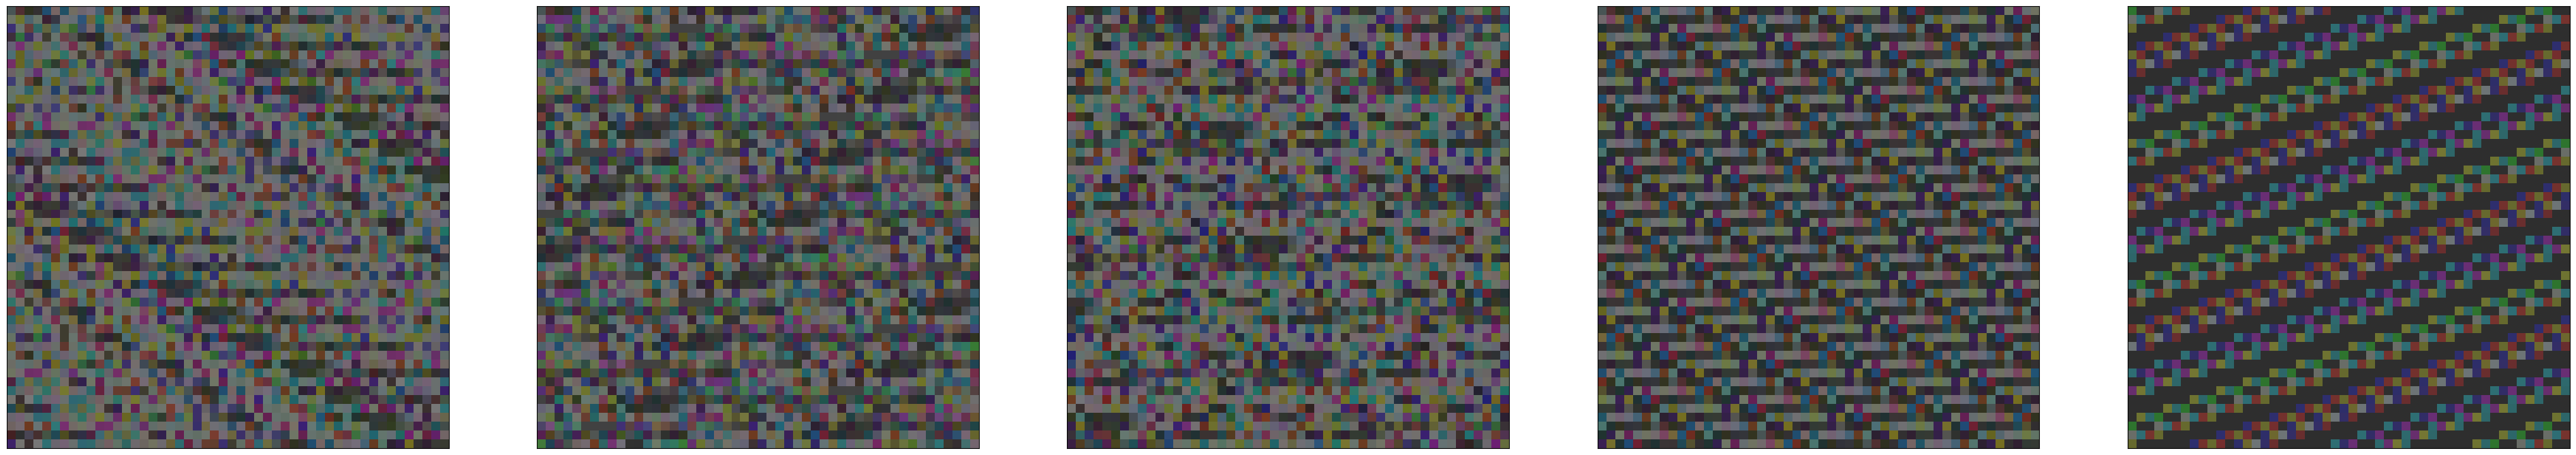

In [17]:
# ploting images for data
%matplotlib inline
n = 40  # how many digits we will display
plt.figure(figsize=(400, 150))
for i in range(6, 11):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(X_train[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
plt.close()

In [18]:
for layer in model_vgg19_conv.layers:
    layer.trainable = False
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [19]:
# x = model_vgg19_conv.output
# x = Flatten()(x)
# x = Dense(128, activation='relu')(x)
# x = Dense(1, activation='sigmoid', name='predictions')(x)
# my_model = Model(inputs=model_vgg19_conv.input, outputs=x)
# my_model.summary()

# Revision 1
# x = model_vgg19_conv.output
# x = Flatten()(x)
# x = Dense(128, activation='relu')(x)
# x = Dense(80, activation='relu')(x)
# x = Dense(1, activation='sigmoid', name='predictions')(x)
# my_model = Model(inputs=model_vgg19_conv.input, outputs=x)
# my_model.summary()

# Revision 2
x = model_vgg19_conv.output
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(1, activation="sigmoid", name="predictions")(x)
my_model = tf.keras.Model(inputs=model_vgg19_conv.input, outputs=x)
my_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [20]:
my_model.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

batch_size = 5
epochs = 3

In [ ]:
hist = my_model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split=0.2,
)

2023-02-23 12:37:39.722947: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3612570000 exceeds 10% of free system memory.
2023-02-23 12:37:42.426600: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3612570000 exceeds 10% of free system memory.


Epoch 1/3


2023-02-23 12:37:45.198996: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101


   10/96336 [..............................] - ETA: 9:51 - loss: 0.5322 - accuracy: 0.8800     

2023-02-23 12:37:47.801532: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:288] gpu_async_0 cuMemAllocAsync failed to allocate 1179910144 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 739704832/6226378752
2023-02-23 12:37:47.801748: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:293] Stats: Limit:                      4302766080
InUse:                      3724632028
MaxInUse:                   4360724444
NumAllocs:                         365
MaxAllocSize:               3612570000
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2023-02-23 12:37:47.801763: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:56] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2023-02-23 12:37:47.801771: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocato

96336/96336 [==============================] - ETA: 0s - loss: 0.0664 - accuracy: 0.9898

2023-02-23 12:47:28.106314: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:288] gpu_async_0 cuMemAllocAsync failed to allocate 1162084352 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 739704832/6226378752
2023-02-23 12:47:28.106350: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:293] Stats: Limit:                      4302766080
InUse:                      3723861272
MaxInUse:                   4903712732
NumAllocs:                    10404679
MaxAllocSize:               3612570000
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2023-02-23 12:47:28.106361: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:56] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2023-02-23 12:47:28.106367: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocato

In [ ]:
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()

In [ ]:
score = my_model.evaluate(X_test, y_test, verbose=0)

In [ ]:
print("Test loss:", score[0])
print("Test accuracy:", score[1])

In [ ]:
training_loss = hist.history["loss"]
val_loss = hist.history["val_loss"]
training_acc = hist.history["acc"]
val_acc = hist.history["val_acc"]
xc = range(epochs)

plt.figure(1, figsize=(7, 5))
plt.plot(xc, training_loss)
plt.plot(xc, val_loss)
plt.xlabel("No. of Epochs")
plt.ylabel("loss")
plt.title("Training Loss vs Validation Loss")
plt.grid(True)
plt.legend(["Train", "Val"])

plt.figure(2, figsize=(7, 5))
plt.plot(xc, training_acc)
plt.plot(xc, val_acc)
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.grid(True)
plt.legend(["Train", "Val"], loc=4)

In [ ]:
checking_occurences = [x for x in y_test if x == 1]
print("total length = ", len(y_test))
print("Anomolies = ", len(checking_occurences))
print("Normal = ", (len(y_test) - len(checking_occurences)))

n = len(y_test) - len(checking_occurences)
a = len(checking_occurences)

label = ["Normal", "Anomaly"]
samples = [n, a]

default_dpi = mpl.rcParamsDefault["figure.dpi"]
mpl.rcParams["figure.dpi"] = default_dpi * 1.5

# this is for plotting purpose
index = np.arange(len(label))
plt.bar(index, samples)
plt.xlabel("Payload Types", fontsize=10)
plt.ylabel("Samples", fontsize=10)
plt.xticks(index, label, fontsize=10, rotation=0)
plt.title("Samples identified by VGG19")
plt.show()

In [ ]:
predictions = my_model.predict(X_test)
print("Predictions = ", predictions)

In [ ]:
rounded = [[round(x[0])] for x in predictions]
from sklearn.metrics import f1_score

result = f1_score(y_test, rounded, average=None, labels=[0, 1])
print("F1 = ", result)

In [ ]:
result = f1_score(y_test, rounded, average="macro")
print("F1 macro = ", result)

In [ ]:
result = f1_score(y_test, rounded, average="micro")
print("F1 Micro= ", result)

In [ ]:
result = f1_score(y_test, rounded, average="weighted")
print("F1 Weighted= ", result)

In [ ]:
import sklearn.metrics

target_names = ["normal", "anomaly"]
print(
    sklearn.metrics.classification_report(
        y_test, rounded, labels=[0, 1], target_names=target_names
    )
)

In [ ]:
my_model.save("FYP_Finalhd5.hd5")
my_model.save("FYP_Finalh5.h5")

In [ ]:
from read_activations import display_activations, get_activations

v_index = 4
x_valid = X_train[:5]
a = get_activations(my_model, x_valid[v_index : v_index + 1], print_shape_only=True)
display_activations(a)